Изучение RNN, датасет jena_climate.

In [1]:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import preprocessing as tfkp
from keras import layers as l
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

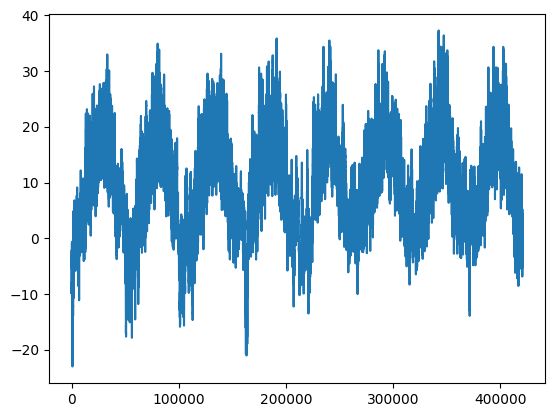

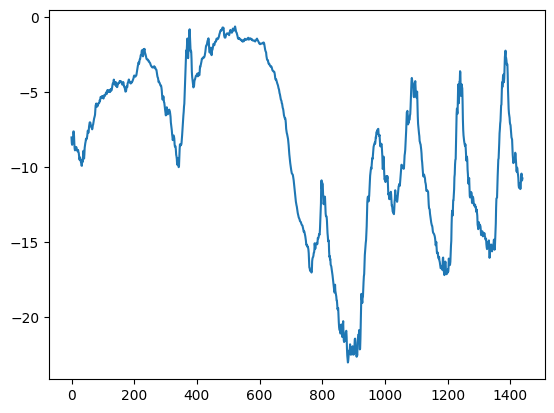

In [5]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.figure()
plt.plot(range(1440), temp[:1440])

plt.show()

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """Функция-генератор данных.
    :data - исходный массив нормализованных вещественных чисел.
    :lookback - количество интервалов в прошлом от заданного момента.
    :delay - количество интервалов в будущем от заданного момента.
    :min_index - индекс в массиве data, ограничивающие область для извлечения данных.
    :max_index - индекс в массиве data, ограничивающие область для извлечения данных.
    :shuffle - флаг, определящий порядок извлечения образцов (с перемешиванием или в хронологическом порядке).
    :batch_size - количество образцов в пакете.
    :step - период в интервалах, из которого извлекается один образец; базово равен 6, чтобы было в 1 образцу в час"""
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
                

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index=200001,
                     max_index=300000,
                     step=step,
                     batch_size=batch_size)

test_gen = generator(float_data,
                     lookback = lookback,
                     delay = delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
# Решение без ML
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print("Средняя абсолютная ошибка:", np.mean(batch_maes))

evaluate_naive_method()


Средняя абсолютная ошибка: 0.2897359729905486


In [9]:
# model = tfk.models.Sequential([
#     l.Flatten(input_shape=(lookback // step, float_data.shape[-1])),
#     l.Dense(32, activation='relu'),
#     l.Dense(1)
# ])

# model.compile(optimizer='rmsprop', loss='mae')
# history = model.fit(train_gen,
#                    steps_per_epoch=500,
#                    epochs=20,
#                    validation_data=val_gen,
#                    validation_steps=val_steps)

In [10]:
def show_res():
    # acc = history.history['acc']
    # val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

#     plt.plot(epochs, acc, 'bo', label='Точность тренировки')
#     plt.plot(epochs, val_acc, 'b', label='Точность проверки')
#     plt.title('Точность тренировки и проверки')
#     plt.legend()

#     plt.figure()

    plt.plot(epochs, loss, 'ro', label='Потери тренировки')
    plt.plot(epochs, val_loss, 'r', label='Потери проверки')
    plt.title('Потери тренировки и проверки')
    plt.legend()

    plt.show()

# show_res()

In [11]:
# model = tfk.models.Sequential([
#     l.GRU(32, input_shape=(None, float_data.shape[-1])),
#     l.Dense(1)
# ])

# model.compile(optimizer='rmsprop', loss='mae')
# history = model.fit(train_gen,
#                    steps_per_epoch=500,
#                    epochs=20,
#                    validation_data=val_gen,
#                    validation_steps=val_steps)

# show_res()

In [12]:
# model = tfk.models.Sequential([
#     l.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])),
#     l.Dense(1)
# ])

# model.compile(optimizer='rmsprop', loss='mae')
# history = model.fit(train_gen,
#                    steps_per_epoch=500,
#                    epochs=40,
#                    validation_data=val_gen,
#                    validation_steps=val_steps)

# show_res()

In [13]:
# model = tfk.models.Sequential([
#     l.GRU(32, dropout=0.1, recurrent_dropout=0.5, return_sequences=True, input_shape=(None, float_data.shape[-1])),
#     l.GRU(64, activation='relu', dropout=0.1, recurrent_dropout=0.5),
#     l.Dense(1)
# ])

# model.compile(optimizer='rmsprop', loss='mae')
# history = model.fit(train_gen,
#                    steps_per_epoch=500,
#                    epochs=40,
#                    validation_data=val_gen,
#                    validation_steps=val_steps)

# show_res()

**Тут начинается фрагмент с изучением IMDB датасета для создания двунаправленной нейронной сети.**

---



In [17]:
from keras.datasets import imdb

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = tfkp.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tfkp.sequence.pad_sequences(x_test, maxlen=maxlen)

model = tfk.models.Sequential([
    l.Embedding(max_features, 128),
    l.LSTM(32),
    l.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 35s 180ms/step - loss: 0.5977 - acc: 0.6550 - val_loss: 0.4187 - val_acc: 0.8300
Epoch 2/10
157/157 [==============================] - 22s 137ms/step - loss: 0.3831 - acc: 0.8422 - val_loss: 0.4918 - val_acc: 0.8284
Epoch 3/10
157/157 [==============================] - 15s 96ms/step - loss: 0.3136 - acc: 0.8764 - val_loss: 0.3074 - val_acc: 0.8818
Epoch 4/10
157/157 [==============================] - 14s 89ms/step - loss: 0.2547 - acc: 0.9054 - val_loss: 0.3481 - val_acc: 0.8814
Epoch 5/10
157/157 [==============================] - 10s 67ms/step - loss: 0.2342 - acc: 0.9156 - val_loss: 0.5335 - val_acc: 0.7586
Epoch 6/10
157/157 [==============================] - 9s 59ms/step - loss: 0.2094 - acc: 0.9261 - val_loss: 0.4866 - val_acc: 0.8506
Epoch 7/10
157/157 [==============================] - 9s 56ms/step - loss: 0.1871 - acc: 0.9347 - val_loss: 0.3371 - val_acc: 0.8796
Epoch 8/10
157/157 [==============================] - 7s 47ms/

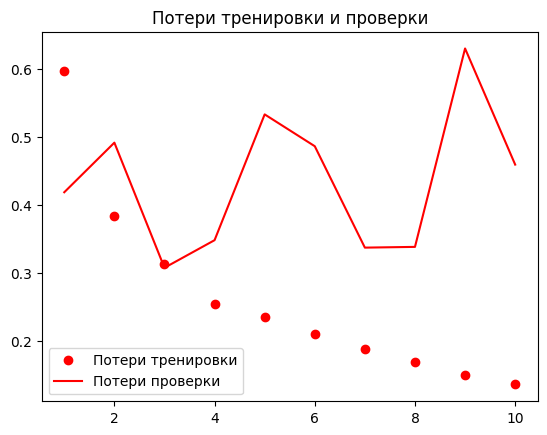

In [18]:
show_res()

Epoch 1/10
157/157 [==============================] - 36s 206ms/step - loss: 0.6678 - acc: 0.5746 - val_loss: 0.5539 - val_acc: 0.7752
Epoch 2/10
157/157 [==============================] - 23s 147ms/step - loss: 0.4445 - acc: 0.8144 - val_loss: 0.3925 - val_acc: 0.8410
Epoch 3/10
157/157 [==============================] - 19s 119ms/step - loss: 0.3190 - acc: 0.8780 - val_loss: 0.5249 - val_acc: 0.8352
Epoch 4/10
157/157 [==============================] - 18s 114ms/step - loss: 0.2749 - acc: 0.9018 - val_loss: 0.4858 - val_acc: 0.8412
Epoch 5/10
157/157 [==============================] - 15s 94ms/step - loss: 0.2404 - acc: 0.9125 - val_loss: 0.3117 - val_acc: 0.8826
Epoch 6/10
157/157 [==============================] - 13s 82ms/step - loss: 0.2126 - acc: 0.9275 - val_loss: 0.3218 - val_acc: 0.8824
Epoch 7/10
157/157 [==============================] - 11s 67ms/step - loss: 0.1869 - acc: 0.9357 - val_loss: 0.3238 - val_acc: 0.8818
Epoch 8/10
157/157 [==============================] - 10s 

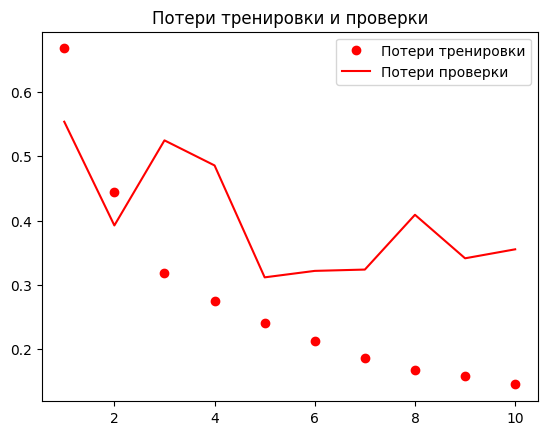

In [19]:
model = tfk.models.Sequential([
    l.Embedding(max_features, 32),
    l.Bidirectional(l.LSTM(32)),
    l.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

show_res()

Epoch 1/40
500/500 [==============================] - 24s 40ms/step - loss: 0.2942 - val_loss: 0.2716
Epoch 2/40
500/500 [==============================] - 19s 38ms/step - loss: 0.2786 - val_loss: 0.2687
Epoch 3/40
500/500 [==============================] - 20s 41ms/step - loss: 0.2709 - val_loss: 0.2693
Epoch 4/40
500/500 [==============================] - 18s 37ms/step - loss: 0.2659 - val_loss: 0.2681
Epoch 5/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2628 - val_loss: 0.2624
Epoch 6/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2570 - val_loss: 0.2677
Epoch 7/40
500/500 [==============================] - 21s 42ms/step - loss: 0.2524 - val_loss: 0.2657
Epoch 8/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2460 - val_loss: 0.2668
Epoch 9/40
500/500 [==============================] - 18s 37ms/step - loss: 0.2401 - val_loss: 0.2746
Epoch 10/40
500/500 [==============================] - 20s 40ms/step - loss: 0.234

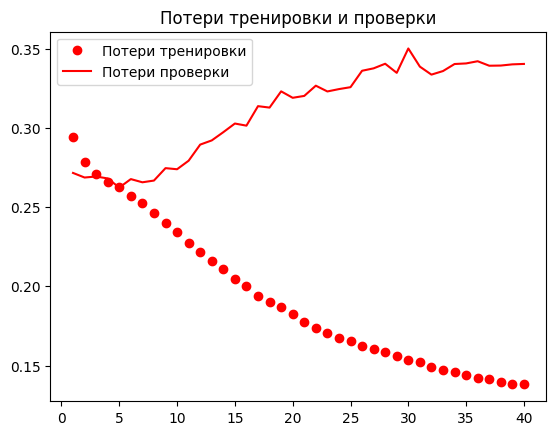

In [20]:
model=tfk.models.Sequential([
    l.Bidirectional(l.GRU(32), input_shape=(None, float_data.shape[-1])),
    l.Dense(1)
])

model.compile(optimizer=tfk.optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

show_res()
